Bu notebook Meta tarafından geliştirilmiş açık kaynak kodlu Facebook Prophet isimli öngörü algoritmasının yapabildiklerini keşfetmek adına oluşturulmuştur.

# Setup

In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import optuna

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.dates as mdates

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
data_seed = 12

# PHASE 1: Load Data 

In [6]:
df = pd.read_csv(r"DATASETS\ForForecast.csv")
df['TransactionDateTime'] = pd.to_datetime(df['TransactionDateTime'])
df.set_index('TransactionDateTime', inplace=True)
df = df.sort_index()

print(f"Shape {df.shape}")
df.tail(10)

Shape (13499, 19)


ChannelKey  DataAreaKey InventKey InventLocationKey  \
TransactionDateTime                                                        
2024-02-08 22:12:00           2            3    others            others   
2024-02-08 22:12:00           2            3    others            others   
2024-02-08 22:12:00           2            3    others            others   
2024-02-08 22:12:00           2            3    others            others   
2024-02-08 22:12:00           2            3    others            others   
2024-02-08 22:28:00           2            3    others            others   
2024-02-08 22:28:00           2            3    others            others   
2024-02-08 22:28:00           2            3    others            others   
2024-02-08 22:28:00           2            3    others            others   
2024-02-08 22:28:00           2            3    others            others   

                    CampaignKrcKey  SalesQuantity  SalesGrossAmount  \
TransactionDateTime                                                   
2024-02-08 22:12:00           6414            4.0            221.01   
2024-02-08 22:12:00           6414            1.0            127.51   
2024-02-08 22:12:00           6414            4.0            221.01   
2024-02-08 22:12:00           6414            1.0            127.52   
2024-02-08 22:12:00           6414            1.0            115.91   
2024-02-08 22:28:00            -99            1.0            110.49   
2024-02-08 22:28:00           6415            3.0            101.99   
2024-02-08 22:28:00              2            1.0            297.49   
2024-02-08 22:28:00            -99            1.0             84.99   
2024-02-08 22:28:00            -99            2.0            305.99   

                     Return_Quantity  NetQuantity  NetGrossAmount  \
TransactionDateTime                                                 
2024-02-08 22:12:00              0.0          4.0          221.01   
2024-02-08 22:12:00              0.0          1.0          127.51   
2024-02-08 22:12:00              0.0          4.0          221.01   
2024-02-08 22:12:00              0.0          1.0          127.52   
2024-02-08 22:12:00              0.0          1.0          115.91   
2024-02-08 22:28:00              0.0          1.0          110.49   
2024-02-08 22:28:00              0.0          3.0          101.99   
2024-02-08 22:28:00              0.0          1.0          297.49   
2024-02-08 22:28:00              0.0          1.0           84.99   
2024-02-08 22:28:00              0.0          2.0          305.99   

                     ReturnGrossAmount  ReturnNetAmount  NetAmountWOVat  \
TransactionDateTime                                                       
2024-02-08 22:12:00                0.0              0.0          184.17   
2024-02-08 22:12:00                0.0              0.0          106.26   
2024-02-08 22:12:00                0.0              0.0          184.17   
2024-02-08 22:12:00                0.0              0.0          106.27   
2024-02-08 22:12:00                0.0              0.0           96.59   
2024-02-08 22:28:00                0.0              0.0           92.07   
2024-02-08 22:28:00                0.0              0.0           84.99   
2024-02-08 22:28:00                0.0              0.0          270.45   
2024-02-08 22:28:00                0.0              0.0           70.83   
2024-02-08 22:28:00                0.0              0.0          254.99   

                     DiscountAmount  DiscountGrossAmount RboStoreKey  \
TransactionDateTime                                                    
2024-02-08 22:12:00          390.71               390.71      others   
2024-02-08 22:12:00          343.07               343.07      others   
2024-02-08 22:12:00          390.71               390.71      others   
2024-02-08 22:12:00          343.06               343.06      others   
2024-02-08 22:12:00          213.49               213.49      others   
2024-02-08 22:28:00  

In [7]:
df.dtypes

ChannelKey               int64
DataAreaKey              int64
InventKey               object
InventLocationKey       object
CampaignKrcKey          object
SalesQuantity          float64
SalesGrossAmount       float64
Return_Quantity        float64
NetQuantity            float64
NetGrossAmount         float64
ReturnGrossAmount      float64
ReturnNetAmount        float64
NetAmountWOVat         float64
DiscountAmount         float64
DiscountGrossAmount    float64
RboStoreKey             object
NetAmount              float64
HourIntervalKey          int64
IsFirstOrder              bool
dtype: object

# PHASE 2: Prepare Data

## Resample and fix

In [8]:
desired_column = 'NetAmountWOVat'

In [9]:
df = df[[desired_column]]

In [10]:
resampled_df = df.resample('60T', closed="left").sum()
resampled_df.shape

(206, 1)

In [11]:
""" Bu notebook'un ana model notebook'larına kıyasla en farklı yanı modelin çalışması için sütunların spesifik isimlerde olmasını talep etmesi """ 

resampled_df.reset_index(inplace=True)
resampled_df = resampled_df.rename(columns={'TransactionDateTime': 'ds', desired_column: 'y'})
resampled_df.head(10)

ds         y
0 2024-01-31 09:00:00   7444.94
1 2024-01-31 10:00:00  16321.85
2 2024-01-31 11:00:00  16112.86
3 2024-01-31 12:00:00   9955.61
4 2024-01-31 13:00:00  36883.48
5 2024-01-31 14:00:00  11374.87
6 2024-01-31 15:00:00  49252.87
7 2024-01-31 16:00:00  65630.39
8 2024-01-31 17:00:00  31425.66
9 2024-01-31 18:00:00  39486.80

In [12]:
resampled_df.dtypes

ds    datetime64[ns]
y            float64
dtype: object

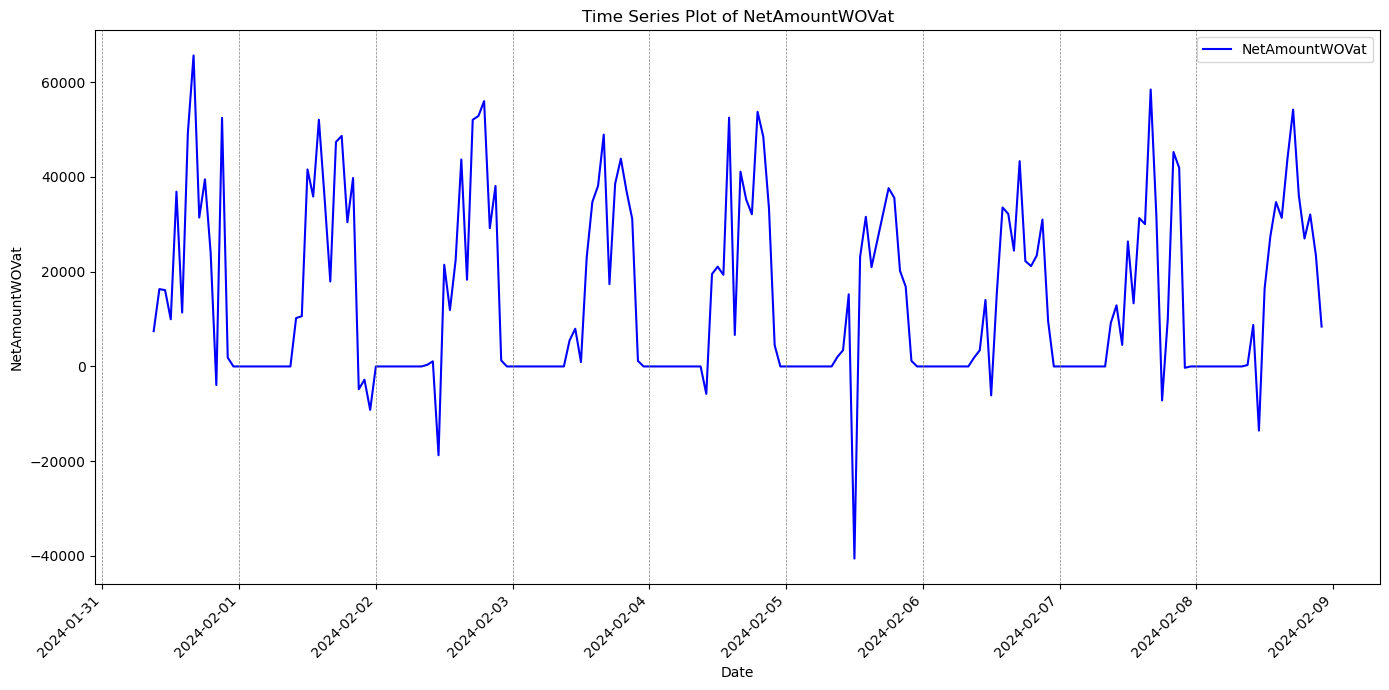

In [13]:
plt.figure(figsize=(14, 7))

plt.plot(resampled_df.ds, resampled_df.y, label=f'{desired_column}', color='blue')

plt.xlabel('Date')
plt.ylabel(f'{desired_column}')
plt.title(f'Time Series Plot of {desired_column}')

plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45, ha='right')

for date in np.unique(resampled_df['ds'].dt.date):
    plt.axvline(x=pd.to_datetime(date), color='gray', linestyle='--', linewidth=0.5)

plt.legend()
plt.tight_layout()
plt.show()

In [14]:
Q1 = resampled_df.y.quantile(0.25)
Q3 = resampled_df.y.quantile(0.75)
IQR = Q3 - Q1

# Define threshold for outliers
lower_bound = Q1 - 1 * IQR
upper_bound = Q3 + 1 * IQR

outliers = resampled_df[(resampled_df.y < lower_bound) | (resampled_df.y > upper_bound)]

resampled_df = resampled_df[(resampled_df.y >= lower_bound) & (resampled_df.y <= upper_bound)]

# Display information about removed outliers
print("Number of outliers removed:", len(outliers))
print("DataFrame size after removing outliers:", len(resampled_df))

Number of outliers removed: 2
DataFrame size after removing outliers: 204


In [15]:
""" 
Bu model Autoregressive özellikte olduğu için ona ""önceki satış" benzeri bir değişken vermek gerekli değildir. Ayrıca her sütuna ayrı bir küçük 
model atadığı için normalizasyon da gerektirmez.
"""

sequence_length = 1

resampled_df["HourInterval"] = resampled_df.ds.dt.hour
resampled_df['DayOfWeek'] = resampled_df.ds.dt.dayofweek + 1

resampled_df = resampled_df.dropna()

In [16]:
print(resampled_df.shape)
resampled_df.head()

(204, 4)


ds         y  HourInterval  DayOfWeek
0 2024-01-31 09:00:00   7444.94             9          3
1 2024-01-31 10:00:00  16321.85            10          3
2 2024-01-31 11:00:00  16112.86            11          3
3 2024-01-31 12:00:00   9955.61            12          3
4 2024-01-31 13:00:00  36883.48            13          3

In [17]:
features = ['HourInterval', 'DayOfWeek']

## Train-Test Split

In [18]:
train_ratio = 0.8  
train_size = int(len(resampled_df) * train_ratio)

train_df = resampled_df[:train_size]
valid_df = resampled_df[train_size:]

In [19]:
print("Train size:", train_size, "Valid Size:", len(resampled_df) - train_size)

Train size: 163 Valid Size: 41


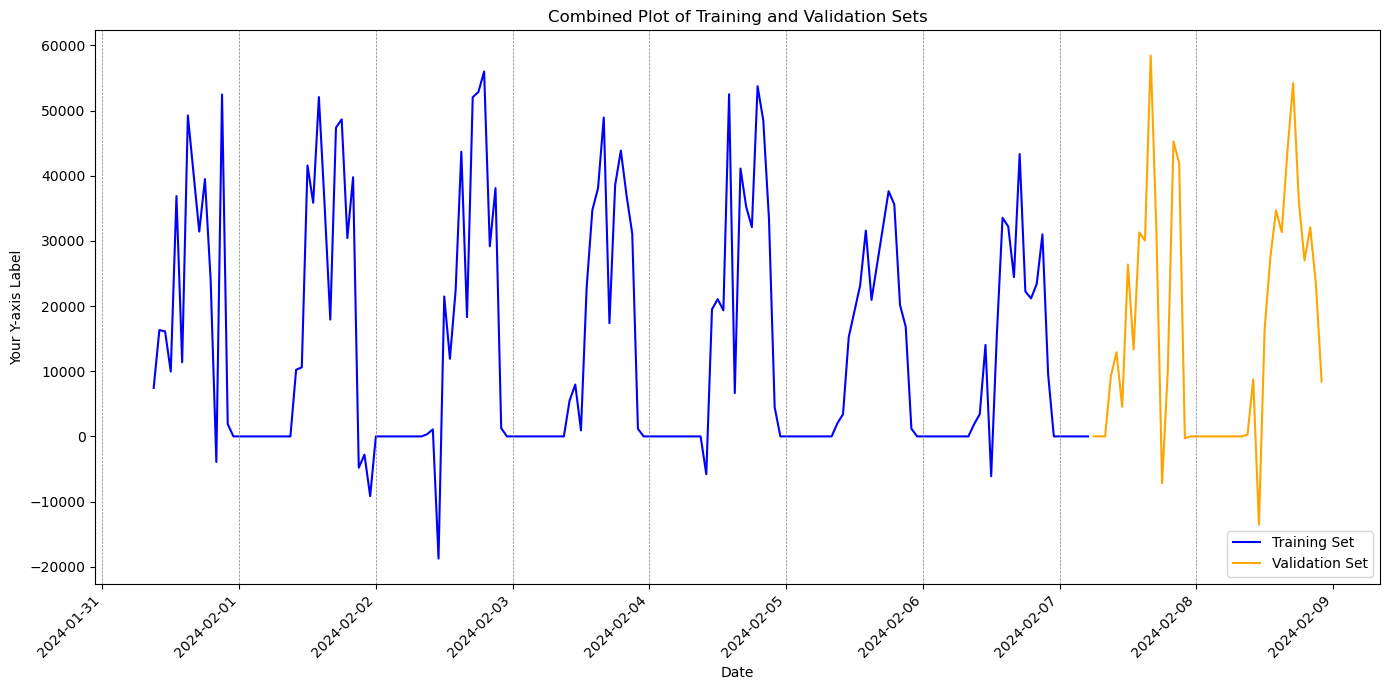

In [20]:
plt.figure(figsize=(14, 7))

plt.plot(train_df.ds, train_df.y, label='Training Set', color='blue')
plt.plot(valid_df.ds, valid_df.y, label='Validation Set', color='orange')

plt.xlabel('Date')
plt.ylabel('Your Y-axis Label')
plt.title('Combined Plot of Training and Validation Sets')

plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45, ha='right')

for date in np.unique(resampled_df['ds'].dt.date):
    plt.axvline(x=pd.to_datetime(date), color='gray', linestyle='--', linewidth=0.5)

plt.legend()
plt.tight_layout()
plt.show()

# PHASE 3: Training

## Main training phase

Bu kısımda 3 farklı Prophet modeli eğitiliyor. Sırasıyla:
* Single Prophet: Fazladan değişken kullanmadan Autoregressive model ailesine ait bir mimari
* Exog Prophet: Single Prophet modeline değişkenlerin ilave edilmiş hali
* Fancy Prophet: Exog Prophet modeline özel günlerin ilave edilmiş hali -bu noktada pek bir işe yaramıyor, ama daha çok veri kullanılırsa farkı anlaşılabilir-.

Modelleri eğitmeden önce Optuna denilen bir kütüphane kullanarak en iyi mimari araması yapılıyor, verinin boyutuna göre bu oldukça uzun sürebilir bu nedenle bu optimizasyon fonksiyonlarını kullanmayabilir ya da arama sayılarını "n_trials=500" azaltabilirsiniz.

In [21]:
from sklearn.metrics import mean_absolute_error

### Prophet - Singular

In [22]:
def find_params_single(trial):
    parameters = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
        'changepoint_range': trial.suggest_float('changepoint_range', 0.1, 0.9),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['multiplicative', 'additive']),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.1, 10),
        'yearly_seasonality': trial.suggest_int('yearly_seasonality', 1, 50),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.1, 10)
        }

    single_prophet_model = Prophet(**parameters) 
    
    single_prophet_model.fit(train_df)
    validation = single_prophet_model.predict(valid_df)
    
    mae_for_optuna = mean_absolute_error(valid_df['y'], validation['yhat'])
    return mae_for_optuna

In [23]:
study = optuna.create_study(direction='minimize')
study.optimize(find_params_single, n_trials=500) 
study.best_params

[I 2024-04-01 08:11:47,865] A new study created in memory with name: no-name-c8bb4490-1b74-49fa-b7cd-13fdab9b7f2b
[I 2024-04-01 08:11:58,195] Trial 0 finished with value: 11342.558043872861 and parameters: {'changepoint_prior_scale': 2.762677586963873, 'changepoint_range': 0.3298708237989348, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.495853526344086, 'yearly_seasonality': 29, 'holidays_prior_scale': 8.156889729441197}. Best is trial 0 with value: 11342.558043872861.
[I 2024-04-01 08:12:06,487] Trial 1 finished with value: 11120.613627043062 and parameters: {'changepoint_prior_scale': 2.467626633150054, 'changepoint_range': 0.2585414379116009, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.028396401384062, 'yearly_seasonality': 31, 'holidays_prior_scale': 5.7043654625446845}. Best is trial 1 with value: 11120.613627043062.
[I 2024-04-01 08:12:13,688] Trial 2 finished with value: 10523.195240195717 and parameters: {'changepoint_prior_scale': 2

{'changepoint_prior_scale': 4.7232816836104,
 'changepoint_range': 0.8635659291397827,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 1.0585314207968057,
 'yearly_seasonality': 3,
 'holidays_prior_scale': 2.0944751507875674}

In [24]:
single_prophet_model = Prophet(**study.best_params) 

In [25]:
print(single_prophet_model.params)
print(single_prophet_model.component_modes)
print(single_prophet_model.extra_regressors)

{}
None
OrderedDict()


In [26]:
single_prophet_model.fit(train_df)

### Prophet - With Exog Variables

In [27]:
def find_params_exog(trial):
    parameters = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
        'changepoint_range': trial.suggest_float('changepoint_range', 0.1, 0.9),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['multiplicative', 'additive']),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.1, 10),
        'yearly_seasonality': trial.suggest_int('yearly_seasonality', 1, 50),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.1, 10)
        }

    exog_prophet_model = Prophet(**parameters)
    for feature in features:  
        exog_prophet_model.add_regressor(feature)
        
    exog_prophet_model.fit(train_df)
    validation = exog_prophet_model.predict(valid_df)
    
    mae_for_optuna = mean_absolute_error(valid_df['y'], validation['yhat'])
    return mae_for_optuna

In [28]:
exog_study = optuna.create_study(direction='minimize')
exog_study.optimize(find_params_exog, n_trials=500) 
exog_study.best_params

[I 2024-04-01 08:34:55,828] A new study created in memory with name: no-name-8781ac26-75a2-4bdb-9b2e-580435f317a5
[I 2024-04-01 08:35:02,876] Trial 0 finished with value: 9843.223870827813 and parameters: {'changepoint_prior_scale': 4.859801194027967, 'changepoint_range': 0.48392440728890107, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.374835060204623, 'yearly_seasonality': 39, 'holidays_prior_scale': 4.260850635897401}. Best is trial 0 with value: 9843.223870827813.
[I 2024-04-01 08:35:07,132] Trial 1 finished with value: 15458.519997351412 and parameters: {'changepoint_prior_scale': 3.01994846031981, 'changepoint_range': 0.3965101572926777, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.336774424922392, 'yearly_seasonality': 41, 'holidays_prior_scale': 4.101610004944015}. Best is trial 0 with value: 9843.223870827813.
[I 2024-04-01 08:35:09,473] Trial 2 finished with value: 6972.646731635983 and parameters: {'changepoint_prior_scale': 0.4929387671

{'changepoint_prior_scale': 2.040856135579862,
 'changepoint_range': 0.3211851079775173,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 8.691201117236675,
 'yearly_seasonality': 3,
 'holidays_prior_scale': 1.526299436366487}

In [29]:
exog_prophet_model = Prophet(**exog_study.best_params) 
for feature in features:  
    exog_prophet_model.add_regressor(feature)

In [30]:
print(exog_prophet_model.params)
print(exog_prophet_model.component_modes)
print(exog_prophet_model.extra_regressors)

{}
None
OrderedDict([('HourInterval', {'prior_scale': 1.526299436366487, 'standardize': 'auto', 'mu': 0.0, 'std': 1.0, 'mode': 'additive'}), ('DayOfWeek', {'prior_scale': 1.526299436366487, 'standardize': 'auto', 'mu': 0.0, 'std': 1.0, 'mode': 'additive'})])


In [31]:
exog_prophet_model.fit(train_df)

In [32]:
import pickle

# Uygulama için kullanmak adına modeli kaydetme kısmı
with open(r'MODELS\exog_prophet_model.pkl', 'wb') as f:
    pickle.dump(exog_prophet_model, f)

### Prophet - Exog + SpecialInfo

In [33]:
def find_params_fancy(trial):
    parameters = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
        'changepoint_range': trial.suggest_float('changepoint_range', 0.1, 0.9),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['multiplicative', 'additive']),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.1, 10),
        'yearly_seasonality': trial.suggest_int('yearly_seasonality', 1, 50),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.1, 10)
        }

    fancy_prophet_model = Prophet(**parameters)
    for feature in features:  
        fancy_prophet_model.add_regressor(feature)
    fancy_prophet_model.add_country_holidays(country_name='TR')
        
    fancy_prophet_model.fit(train_df)
    validation = fancy_prophet_model.predict(valid_df)
    
    mae_for_optuna = mean_absolute_error(valid_df['y'], validation['yhat'])
    return mae_for_optuna

In [34]:
fancy_study = optuna.create_study(direction='minimize')
fancy_study.optimize(find_params_fancy, n_trials=500) 
fancy_study.best_params

[I 2024-04-01 08:51:21,915] A new study created in memory with name: no-name-39638721-7cd9-4d63-b5f3-8a97f992b24a
[I 2024-04-01 08:51:33,894] Trial 0 finished with value: 9326.16599422587 and parameters: {'changepoint_prior_scale': 4.257723885508723, 'changepoint_range': 0.777084061465398, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 3.153847965736728, 'yearly_seasonality': 35, 'holidays_prior_scale': 3.7127353159902654}. Best is trial 0 with value: 9326.16599422587.
[I 2024-04-01 08:51:35,856] Trial 1 finished with value: 11571.461416770579 and parameters: {'changepoint_prior_scale': 0.3824885647855145, 'changepoint_range': 0.4876611491405557, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.565448137172257, 'yearly_seasonality': 32, 'holidays_prior_scale': 7.726474058890614}. Best is trial 0 with value: 9326.16599422587.
[I 2024-04-01 08:51:39,768] Trial 2 finished with value: 8355.605426796139 and parameters: {'changepoint_prior_scale': 3.541576

{'changepoint_prior_scale': 2.1120781910369235,
 'changepoint_range': 0.15382781771483367,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 6.13073193012456,
 'yearly_seasonality': 6,
 'holidays_prior_scale': 4.986180928497964}

In [35]:
fancy_prophet_model = Prophet(**fancy_study.best_params) 
for feature in features:  
    fancy_prophet_model.add_regressor(feature)
fancy_prophet_model.add_country_holidays(country_name='TR')

In [36]:
print(fancy_prophet_model.params)
print(fancy_prophet_model.component_modes)
print(fancy_prophet_model.extra_regressors)

{}
None
OrderedDict([('HourInterval', {'prior_scale': 4.986180928497964, 'standardize': 'auto', 'mu': 0.0, 'std': 1.0, 'mode': 'additive'}), ('DayOfWeek', {'prior_scale': 4.986180928497964, 'standardize': 'auto', 'mu': 0.0, 'std': 1.0, 'mode': 'additive'})])


In [37]:
fancy_prophet_model.fit(train_df)

# PHASE 4: Testing

## Plot inference

In [38]:
## Singular Prophet
single_train_forecast = single_prophet_model.predict(train_df)
single_valid_forecast = single_prophet_model.predict(valid_df)

## Prophet + Exog
exog_train_forecast = exog_prophet_model.predict(train_df)
exog_valid_forecast = exog_prophet_model.predict(valid_df)

## Prophet + Exog + SpecialFeatures
fancy_train_forecast = fancy_prophet_model.predict(train_df)
fancy_valid_forecast = fancy_prophet_model.predict(valid_df)

## Ensemble
ensemble_train_forecast = pd.DataFrame()
ensemble_train_forecast['yhat'] = (single_train_forecast["yhat"] + exog_train_forecast["yhat"] + fancy_train_forecast["yhat"]) / 3
ensemble_train_forecast['ds'] = single_train_forecast["ds"]

ensemble_valid_forecast = pd.DataFrame()
ensemble_valid_forecast['yhat'] = (single_valid_forecast["yhat"] + exog_valid_forecast["yhat"] + fancy_valid_forecast["yhat"]) / 3
ensemble_valid_forecast['ds'] = single_valid_forecast["ds"]

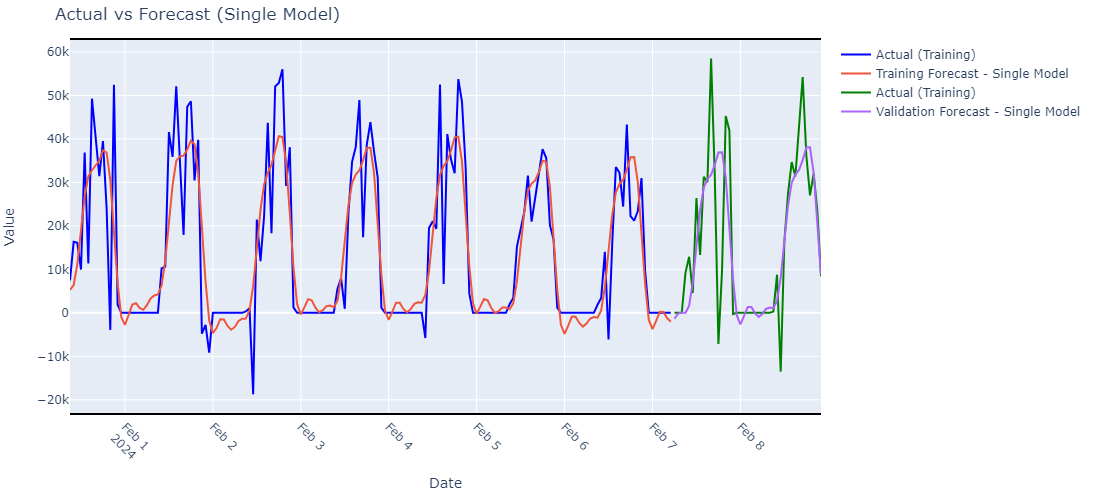

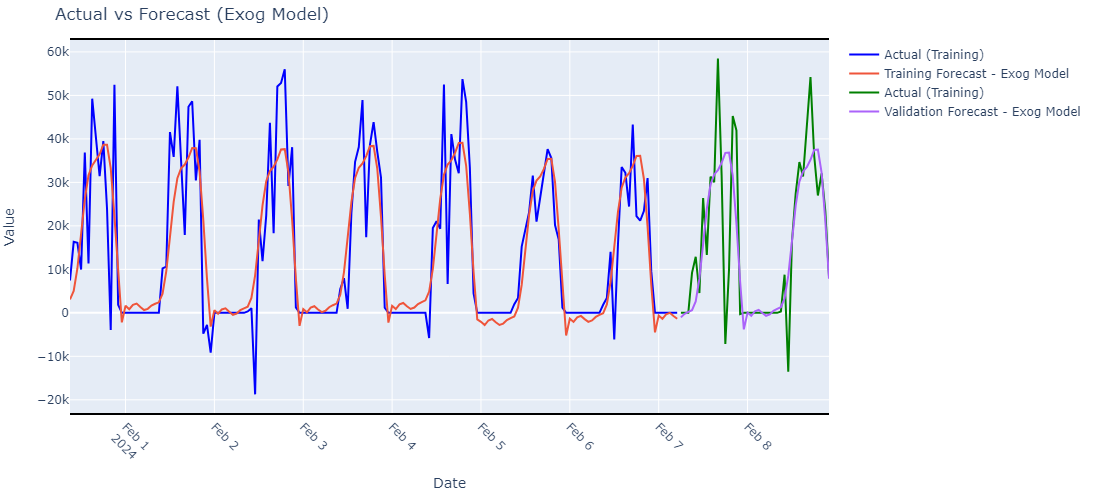

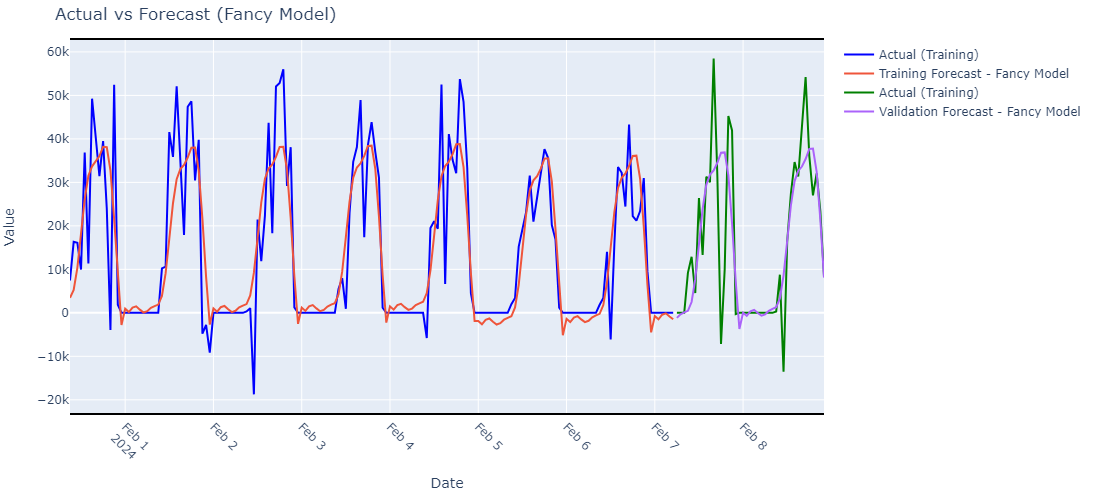

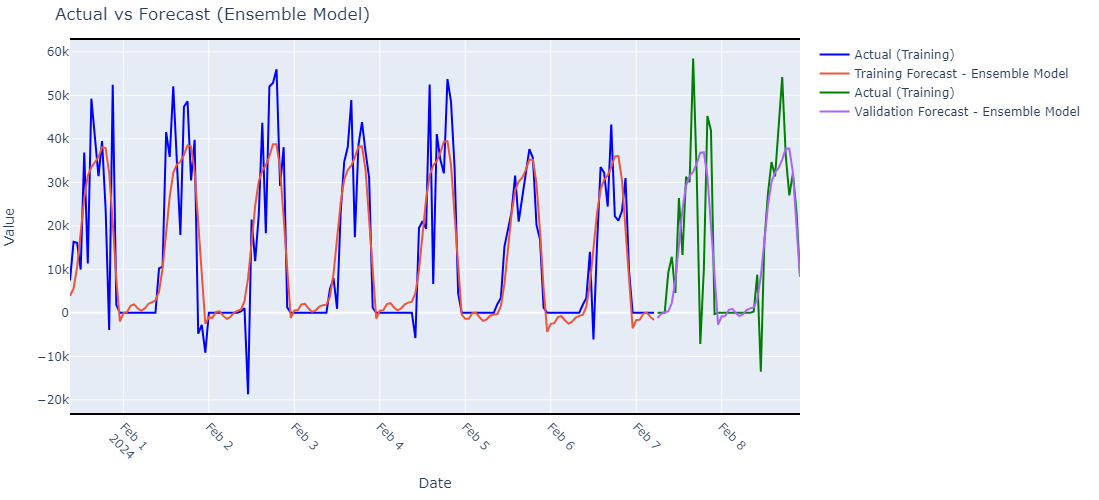

In [39]:
import plotly.graph_objects as go

## Asıl
trace_actual_train = go.Scatter(x=train_df.ds, y=train_df.y, mode='lines', name='Actual (Training)', line=dict(color='blue'))
trace_actual_valid = go.Scatter(x=valid_df.ds, y=valid_df.y, mode='lines', name='Actual (Training)', line=dict(color='green'))

# Single Model
trace_single_train = go.Scatter(x=single_train_forecast['ds'], y=single_train_forecast['yhat'], mode='lines', name='Training Forecast - Single Model')
trace_single_valid = go.Scatter(x=single_valid_forecast['ds'], y=single_valid_forecast['yhat'], mode='lines', name='Validation Forecast - Single Model')

# Exog Model
trace_exog_train = go.Scatter(x=exog_train_forecast['ds'], y=exog_train_forecast['yhat'], mode='lines', name='Training Forecast - Exog Model')
trace_exog_valid = go.Scatter(x=exog_valid_forecast['ds'], y=exog_valid_forecast['yhat'], mode='lines', name='Validation Forecast - Exog Model')

# Fancy Model
trace_fancy_train = go.Scatter(x=fancy_train_forecast['ds'], y=fancy_train_forecast['yhat'], mode='lines', name='Training Forecast - Fancy Model')
trace_fancy_valid = go.Scatter(x=fancy_valid_forecast['ds'], y=fancy_valid_forecast['yhat'], mode='lines', name='Validation Forecast - Fancy Model')

# Ensemble Model
trace_ensemble_train = go.Scatter(x=ensemble_train_forecast["ds"], y=ensemble_train_forecast['yhat'], mode='lines', name='Training Forecast - Ensemble Model')
trace_ensemble_valid = go.Scatter(x=ensemble_valid_forecast["ds"], y=ensemble_valid_forecast['yhat'], mode='lines', name='Validation Forecast - Ensemble Model')

layout_single = go.Layout(
    title='Actual vs Forecast (Single Model)',
    xaxis=dict(title='Date', tickangle=45, showline=True, linewidth=2, linecolor='black', mirror=True),
    yaxis=dict(title='Value'),
    height=500,
    width=1100,
    margin=dict(l=40, r=40, b=40, t=40)
)

layout_exog = go.Layout(
    title='Actual vs Forecast (Exog Model)',
    xaxis=dict(title='Date', tickangle=45, showline=True, linewidth=2, linecolor='black', mirror=True),
    yaxis=dict(title='Value'),
    height=500,
    width=1100,
    margin=dict(l=40, r=40, b=40, t=40)
)

layout_fancy = go.Layout(
    title='Actual vs Forecast (Fancy Model)',
    xaxis=dict(title='Date', tickangle=45, showline=True, linewidth=2, linecolor='black', mirror=True),
    yaxis=dict(title='Value'),
    height=500,
    width=1100,
    margin=dict(l=40, r=40, b=40, t=40)
)

layout_ensemble = go.Layout(
    title='Actual vs Forecast (Ensemble Model)',
    xaxis=dict(title='Date', tickangle=45, showline=True, linewidth=2, linecolor='black', mirror=True),
    yaxis=dict(title='Value'),
    height=500,
    width=1100,
    margin=dict(l=40, r=40, b=40, t=40)
)

fig_single = go.Figure(data=[trace_actual_train, trace_single_train, trace_actual_valid, trace_single_valid], layout=layout_single)
fig_exog = go.Figure(data=[trace_actual_train, trace_exog_train, trace_actual_valid, trace_exog_valid], layout=layout_exog)
fig_fancy = go.Figure(data=[trace_actual_train, trace_fancy_train, trace_actual_valid, trace_fancy_valid], layout=layout_fancy)
fig_ensemble = go.Figure(data=[trace_actual_train, trace_ensemble_train, trace_actual_valid, trace_ensemble_valid], layout=layout_ensemble)

fig_single.show()
fig_exog.show()
fig_fancy.show()
fig_ensemble.show()

## Table Inference

In [40]:
predictions_train_df = pd.DataFrame({
    'Date': train_df.ds,
    'Actual': train_df.y,
    'Single Model Predicted': single_train_forecast.yhat,
    'Exog Model Predicted': exog_train_forecast.yhat,
    'Fancy Model Predicted': fancy_train_forecast.yhat,
    'Ensemble Model Predicted': ensemble_train_forecast.yhat,
})

predictions_valid_df = pd.DataFrame({
    'Date': valid_df.ds,
    'Actual': valid_df.y,
    'Single Model Predicted': single_valid_forecast.yhat,
    'Exog Model Predicted': exog_valid_forecast.yhat,
    'Fancy Model Predicted': fancy_valid_forecast.yhat,
    'Ensemble Model Predicted': ensemble_valid_forecast.yhat,
})

predictions_all_df = pd.concat([predictions_train_df, predictions_valid_df], ignore_index=True)
predictions_all_df.set_index('Date', inplace=True)

result_df = predictions_all_df.copy()
result_df.head(50)

Actual  Single Model Predicted  Exog Model Predicted  \
Date                                                                          
2024-01-31 09:00:00   7444.94             5261.557698           3088.092085   
2024-01-31 10:00:00  16321.85             6395.754708           5041.257902   
2024-01-31 11:00:00  16112.86            11210.627048          10196.062184   
2024-01-31 12:00:00   9955.61            19023.408387          18100.320317   
2024-01-31 13:00:00  36883.48            26734.060094          26159.456189   
2024-01-31 14:00:00  11374.87            31406.908298          31630.181013   
2024-01-31 15:00:00  49252.87            32801.508026          33907.378994   
NaT                       NaN            35016.557775          36447.934168   
2024-01-31 17:00:00  31425.66            37355.762714          38664.291819   
2024-01-31 18:00:00  39486.80            36872.297359          38651.322858   
2024-01-31 19:00:00  24004.20            30501.072599          33287.653885   
2024-01-31 20:00:00  -3930.48            18756.316605          22230.920425   
2024-01-31 21:00:00  52459.47             6856.268554           8790.728730   
2024-01-31 22:00:00   1879.17            -1000.800929          -2195.167923   
2024-01-31 23:00:00      0.00            -2768.384443           1618.592307   
2024-02-01 00:00:00      0.00             -515.609619            822.796036   
2024-02-01 01:00:00      0.00             1897.462603           1828.912684   
2024-02-01 02:00:00      0.00             2207.832953           2112.662528   
2024-02-01 03:00:00      0.00             1135.289185           1322.022681   
2024-02-01 04:00:00      0.00              686.493002            641.275196   
2024-02-01 05:00:00      0.00             1750.862317            912.269893   
2024-02-01 06:00:00      0.00             3295.201967           1678.841441   
2024-02-01 07:00:00      0.00             3984.535512           2082.619935   
2024-02-01 08:00:00      0.00             4232.553350           2416.093834   
2024-02-01 09:00:00      0.00             6275.721322           4388.572587   
2024-02-01 10:00:00  10213.80            11999.565908           9551.749312   
2024-02-01 11:00:00  10608.78            20721.320778          17464.380119   
2024-02-01 12:00:00  41577.63            29340.947298          25531.888872   
2024-02-01 13:00:00  35860.47            34922.771600          30976.346164   
2024-02-01 14:00:00  52076.60            35995.271287          33227.276822   
2024-02-01 15:00:00  35542.99            36144.251337          34104.281178   
2024-02-01 16:00:00  17930.29            37566.107798          35715.282028   
2024-02-01 17:00:00  47382.29            39583.208043          37905.365017   
2024-02-01 18:00:00  48652.41            38777.639276          37859.704866   
2024-02-01 19:00:00  30437.08            32171.200463          32463.344946   
2024-02-01 20:00:00  39773.96            20191.231699          21360.515385   
2024-02-01 21:00:00  -4807.72             7185.216743           7874.235760   
2024-02-01 22:00:00  -2797.72            -1777.818363          -3157.749610   
2024-02-01 23:00:00  -9165.83            -4651.366219            620.241540   
2024-02-02 00:00:00      0.00            -3504.554456           -211.323592   
2024-02-02 01:00:00      0.00            -1469.699043            772.421297   
2024-02-02 02:00:00      0.00            -1537.544222           1033.799652   
2024-02-02 03:00:00      0.00            -3026.492746            236.890592   
2024-02-02 04:00:00      0.00            -3891.692404           -450.125871   
2024-02-02 05:00:00      0.00            -3243.725283           -169.326632   
2024-02-02 06:00:00      0.00            -1875.073600            607.049710   
2024-02-02 07:00:00      0.00            -1361.426743           1037.077921   
2024-02-02 08:00:00      0.00            -1289.094562           1396.801895   
2024-02-02 09:00:00    333.32              578.389033           3410.6834

In [41]:
real_values = result_df['Actual'].sum()
single_model_values = result_df['Single Model Predicted'].sum()
exog_model_values = result_df['Exog Model Predicted'].sum()
fancy_model_values = result_df['Fancy Model Predicted'].sum()
ensemble_model_values = result_df['Ensemble Model Predicted'].sum()

print(f"Real Sales:", real_values)
print(f"Single Model Sales:", single_model_values, f", Exog Model Sales:", exog_model_values, f", Fancy Model Sales:", fancy_model_values, f", Ensemble Model Sales:", ensemble_model_values)

print("-------------------------------------------")

print("The prediction offness:")
print("Single Model:", int(single_model_values - real_values), ", Exog Model:", int(exog_model_values - real_values), ", Fancy Model:", int(fancy_model_values - real_values), ", Ensemble Model:", int(ensemble_model_values - real_values))

Real Sales: 2839897.51
Single Model Sales: 2826395.567799798 , Exog Model Sales: 2832151.3717989344 , Fancy Model Sales: 2833361.404601992 , Ensemble Model Sales: 2830636.114733575
-------------------------------------------
The prediction offness:
Single Model: -13501 , Exog Model: -7746 , Fancy Model: -6536 , Ensemble Model: -9261


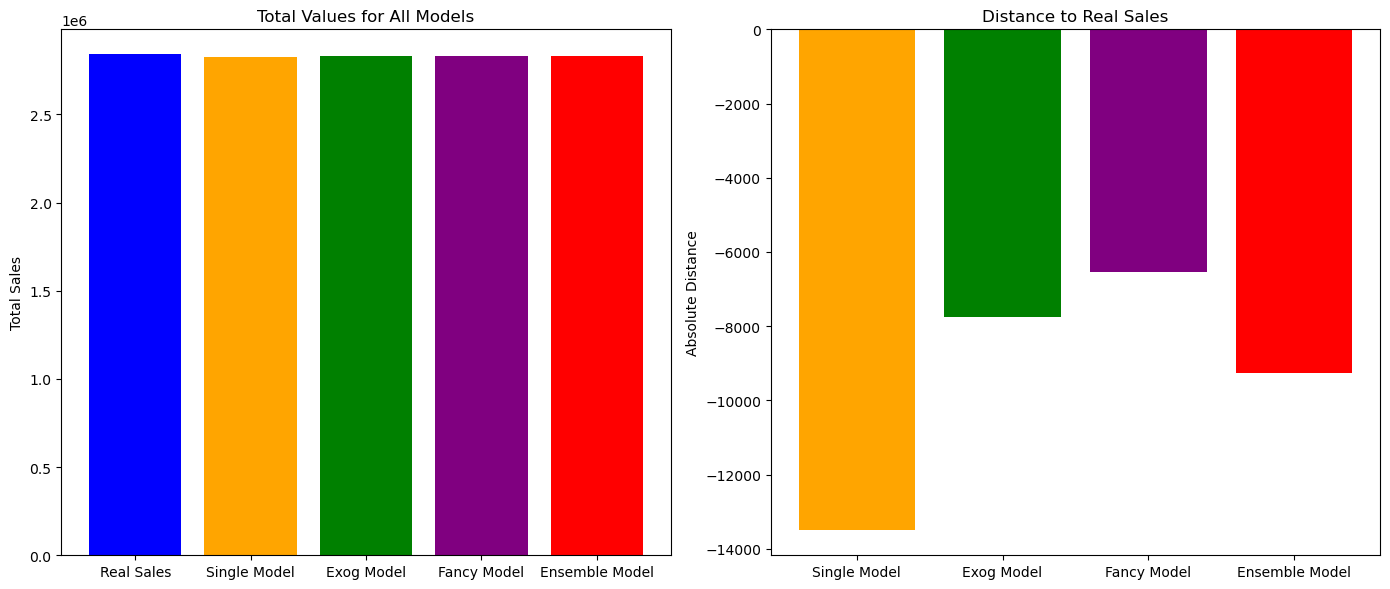

In [42]:
distance_single_model = single_model_values - real_values
distance_exog_model = exog_model_values - real_values
distance_fancy_model = fancy_model_values - real_values
distance_ensemble_model = ensemble_model_values - real_values

# Create subplots with two columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot total values for all models
axes[0].bar(['Real Sales', 'Single Model', 'Exog Model', 'Fancy Model', 'Ensemble Model'],
            [real_values, single_model_values, exog_model_values, fancy_model_values, ensemble_model_values],
            color=['blue', 'orange', 'green', 'purple', 'red'])
axes[0].set_title('Total Values for All Models')
axes[0].set_ylabel('Total Sales')

# Plot distance to real values for each model
axes[1].bar(['Single Model', 'Exog Model', 'Fancy Model', 'Ensemble Model'],
            [distance_single_model, distance_exog_model, distance_fancy_model, distance_ensemble_model],
            color=['orange', 'green', 'purple', 'red'])
axes[1].set_title('Distance to Real Sales')
axes[1].set_ylabel('Absolute Distance')

# Adjust layout for better readability
plt.tight_layout()

# Display the plots
plt.show()

# PHASE 5: Forecasting

## Prepare the emtpy set

In [43]:
start_timestamp = '2024-02-08 21:00:00'
end_timestamp = '2024-02-18 23:00:00'

forecast_df = pd.DataFrame()

forecast_df['ds'] = pd.date_range(start=start_timestamp, end=end_timestamp, freq='H')
forecast_df['y'] = np.nan

forecast_df["HourInterval"] = forecast_df.ds.dt.hour
forecast_df['DayOfWeek'] = forecast_df.ds.dt.dayofweek + 1

forecast_df.head(4)

ds   y  HourInterval  DayOfWeek
0 2024-02-08 21:00:00 NaN            21          4
1 2024-02-08 22:00:00 NaN            22          4
2 2024-02-08 23:00:00 NaN            23          4
3 2024-02-09 00:00:00 NaN             0          5

In [44]:
print(forecast_df.shape)
forecast_df.head(6)

(243, 4)


ds   y  HourInterval  DayOfWeek
0 2024-02-08 21:00:00 NaN            21          4
1 2024-02-08 22:00:00 NaN            22          4
2 2024-02-08 23:00:00 NaN            23          4
3 2024-02-09 00:00:00 NaN             0          5
4 2024-02-09 01:00:00 NaN             1          5
5 2024-02-09 02:00:00 NaN             2          5

## Forecasts

In [45]:
""" Prophet modelleri "önceki satış" gibi bir değişken kullanmadığı için onunla toplu öngörülerde bulunmak mümkün """

############################## Single Prophet ###########################################
single_model_forecast_df= single_prophet_model.predict(forecast_df)
single_model_forecast_df.tail()

############################## Exog Prophet ###########################################

exog_model_forecast_df = exog_prophet_model.predict(forecast_df)
exog_model_forecast_df.tail()

############################## Fancy Prophet ###########################################

fancy_model_forecast_df= fancy_prophet_model.predict(forecast_df)
fancy_model_forecast_df.tail()

ds         trend    yhat_lower    yhat_upper  \
238 2024-02-18 19:00:00  33572.568004  34423.308821  66584.203538   
239 2024-02-18 20:00:00  33623.591024  28472.902517  61362.012083   
240 2024-02-18 21:00:00  33674.614044  17499.108275  51016.737896   
241 2024-02-18 22:00:00  33725.637065   5023.498199  36702.431833   
242 2024-02-18 23:00:00  33776.660085  -5611.511109  26404.868997   

      trend_lower   trend_upper  \
238  22001.381146  43817.920732   
239  21995.877613  43944.778664   
240  21988.265616  44071.636596   
241  21980.653620  44198.494528   
242  21973.511319  44323.765692   

     Commemoration of Ataturk, Youth and Sports Day  \
238                                             0.0   
239                                             0.0   
240                                             0.0   
241                                             0.0   
242                                             0.0   

     Commemoration of Ataturk, Youth and Sports Day_lower  \
238                                                0.0      
239                                                0.0      
240                                                0.0      
241                                                0.0      
242                                                0.0      

     Commemoration of Ataturk, Youth and Sports Day_upper    DayOfWeek  \
238                                                0.0     1592.183657   
239                                                0.0     1592.183657   
240                                                0.0     1592.183657   
241                                                0.0     1592.183657   
242                                                0.0     1592.183657   

     DayOfWeek_lower  DayOfWeek_upper  Democracy and National Unity Day  \
238      1592.183657      1592.183657                               0.0   
239      1592.183657      1592.183657                               0.0   
240      1592.183657      1592.183657                               0.0   
241      1592.183657      1592.183657                               0.0   
242      1592.183657      1592.183657                               0.0   

     Democracy and National Unity Day_lower  \
238                                     0.0   
239                                     0.0   
240                                     0.0   
241                                     0.0   
242                                     0.0   

     Democracy and National Unity Day_upper  HourInterval  HourInterval_lower  \
238                                     0.0  -2711.246696        -2711.246696   
239                                     0.0  -3075.277348        -3075.277348   
240                                     0.0  -3439.308000        -3439.308000   
241                                     0.0  -3803.338651        -3803.338651   
242                                     0.0  -4167.369303        -4167.369303   

     HourInterval_upper  Labour Day  Labour Day_lower  Labour Day_upper  \
238        -2711.246696         0.0               0.0               0.0   
239        -3075.277348         0.0               0.0               0.0   
240        -3439.308000         0.0               0.0               0.0   
241        -3803.338651         0.0               0.0               0.0   
242        -4167.369303         0.0               0.0               0.0   

     National Sovereignty and Children's Day  \
238                                      0.0   
239                                      0.0   
240                                      0.0   
241                                      0.0   
242                                      0.0   

     National Sovereignty and Children's Day_lower  \
238                                            0.0   
239                                            0.0   
240                                            0.0   
241                                            0.0   
242                  

In [46]:
ensemble_forecast_df = pd.DataFrame()
ensemble_forecast_df["ds"] = single_model_forecast_df.ds
ensemble_forecast_df['yhat'] = (single_model_forecast_df['yhat'] + exog_model_forecast_df['yhat'] + fancy_model_forecast_df['yhat']) / 3

## Plot Inference

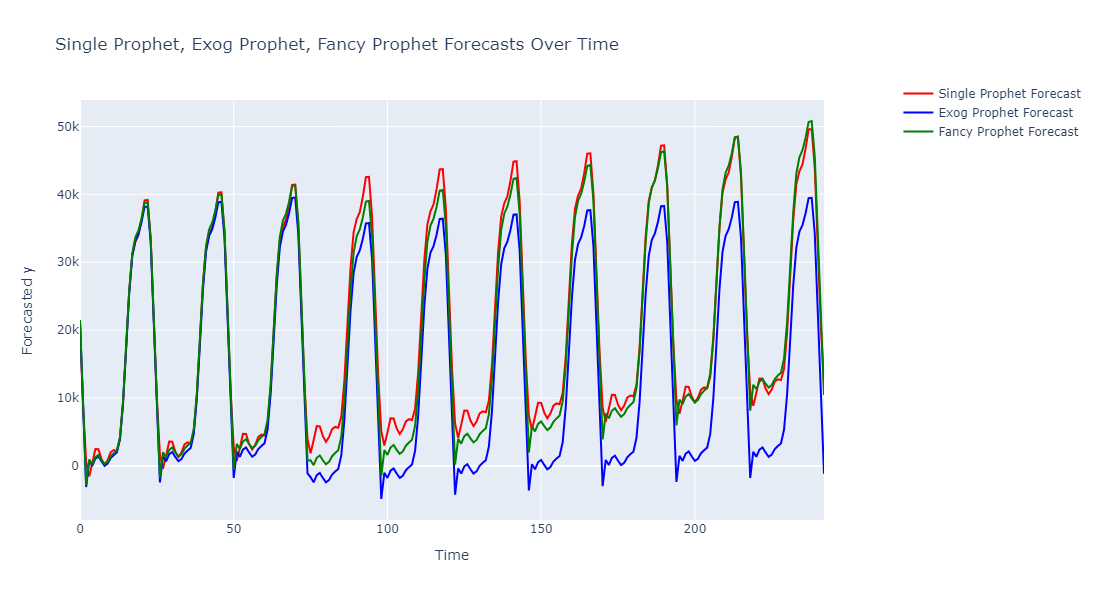

In [47]:
trace_single = go.Scatter(x=single_model_forecast_df.index, y=single_model_forecast_df['yhat'], mode='lines', name='Single Prophet Forecast', line=dict(color='red'))
trace_exog = go.Scatter(x=exog_model_forecast_df.index, y=exog_model_forecast_df['yhat'], mode='lines', name='Exog Prophet Forecast', line=dict(color='blue'))
trace_fancy = go.Scatter(x=fancy_model_forecast_df.index, y=fancy_model_forecast_df['yhat'], mode='lines', name='Fancy Prophet Forecast', line=dict(color='green'))

layout = go.Layout(title='Single Prophet, Exog Prophet, Fancy Prophet Forecasts Over Time',
                   xaxis=dict(title='Time'),
                   yaxis=dict(title='Forecasted y'),
                   legend=dict(x=1.1, y=1.05, traceorder='normal'),  # Adjust legend position
                   width=1200,  # Set the width of the plot
                   height=600)  # Set the height of the plot

fig = go.Figure(data=[trace_single, trace_exog, trace_fancy], layout=layout)

fig.show()

## Table Inference

In [48]:
single_model_forecast_df = single_model_forecast_df.rename(columns={'yhat': 'Single Prophet'})
exog_model_forecast_df = exog_model_forecast_df.rename(columns={'yhat': 'Exog Prophet'})
fancy_model_forecast_df = fancy_model_forecast_df.rename(columns={'yhat': 'Fancy Prophet'})
ensemble_forecast_df = ensemble_forecast_df.rename(columns={'yhat': 'Ensemble'})

# Concatenate the forecasts into a single DataFrame
predictions_df = pd.concat([single_model_forecast_df["Single Prophet"], exog_model_forecast_df["Exog Prophet"], fancy_model_forecast_df["Fancy Prophet"], ensemble_forecast_df["Ensemble"]], axis=1)
predictions_df.index = single_model_forecast_df["ds"]

# Display the resulting DataFrame
predictions_df

Single Prophet  Exog Prophet  Fancy Prophet      Ensemble
ds                                                                            
2024-02-08 21:00:00    21007.698642  21219.154556   21490.730469  21239.194556
2024-02-08 22:00:00     8771.229726   7826.902154    8107.168765   8235.100215
2024-02-08 23:00:00      577.749280  -3111.053124   -2815.035151  -1782.779665
2024-02-09 00:00:00    -1526.235299    750.651590     954.482888     59.633059
2024-02-09 01:00:00      390.148350      2.802915     223.623494    205.524920
2024-02-09 02:00:00     2466.839285   1056.870298    1287.961538   1603.890374
2024-02-09 03:00:00     2440.838229   1388.574066    1627.075397   1818.829231
2024-02-09 04:00:00      993.742423    645.891311     895.453453    845.029062
2024-02-09 05:00:00      170.404072     13.104100     278.586235    154.031469
2024-02-09 06:00:00      860.241084    332.062269     612.036564    601.446639
2024-02-09 07:00:00     2030.058290   1146.600511    1432.403540   1536.354114
2024-02-09 08:00:00     2344.879246   1598.348927    1882.065781   1941.764651
2024-02-09 09:00:00     2218.394093   1979.796104    2264.096700   2154.095632
2024-02-09 10:00:00     3887.068917   4000.251393    4300.138690   4062.486333
2024-02-09 11:00:00     9236.430191   9222.348623    9555.990327   9338.256381
2024-02-09 12:00:00    17583.711580  17193.903223   17570.171550  17449.262118
2024-02-09 13:00:00    25828.874446  25320.339071   25734.220761  25627.811426
2024-02-09 14:00:00    31036.244912  30858.367332   31298.306294  31064.306180
2024-02-09 15:00:00    32965.378000  33202.872292   33663.022501  33277.090931
2024-02-09 16:00:00    33971.001257  34173.462201   34659.395619  34267.953025
2024-02-09 17:00:00    36249.510728  35878.051966   36400.920727  36176.161140
2024-02-09 18:00:00    39123.273778  38161.727246   38726.916751  38670.639259
2024-02-09 19:00:00    39174.377607  38209.662777   38810.942686  38731.661023
2024-02-09 20:00:00    33337.733097  32906.901923   33531.393475  33258.676165
2024-02-09 21:00:00    22127.568414  21897.674848   22536.429747  22187.224336
2024-02-09 22:00:00     9891.367311   8504.993198    9158.956392   9185.105633
2024-02-09 23:00:00     1698.155823  -2433.390747   -1757.154983   -830.796636
2024-02-10 00:00:00     -405.558655   1427.885884    2018.459688   1013.595639
2024-02-10 01:00:00     1511.096240    679.609710    1293.700912   1161.468954
2024-02-10 02:00:00     3588.059562   1733.250181    2364.143458   2561.817733
2024-02-10 03:00:00     3562.332033   2064.527624    2709.365599   2778.741752
2024-02-10 04:00:00     2115.510894   1321.419135    1983.855613   1806.928548
2024-02-10 05:00:00     1292.448349    688.206781    1373.103928   1117.919686
2024-02-10 06:00:00     1982.562303   1006.740398    1712.673260   1567.325321
2024-02-10 07:00:00     3152.657588   1820.854684    2539.162607   2504.224960
2024-02-10 08:00:00     3467.757756   2272.179741    2994.950483   2911.629326
2024-02-10 09:00:00     3341.552949   2653.204155    3383.110197   3125.955767
2024-02-10 10:00:00     5010.509251   4673.237282    5425.284039   5036.343524
2024-02-10 11:00:00    10360.153135   9894.912950   10687.270483  10314.112189
2024-02-10 12:00:00    18707.718263  17866.046591   18707.589364  18427.118073
2024-02-10 13:00:00    26953.165996  25992.062084   26877.778979  26607.669020
2024-02-10 14:00:00    32160.822456  31529.670597   32448.007560  32046.166871
2024-02-10 15:00:00    34090.242664  33873.756416   34818.869358  34260.956146
2024-02-10 16:00:00    35096.154165  34843.927793   35821.390502  35253.824154
2024-02-10 17:00:00    37374.953005  36548.099637   37569.065971  37164.039538
2024-02-10 18:00:00    40249.006545  38831.357609   39901.214589  39660.526247
2024-02-10 19:00:00    40300.401984  38878.876445   39991.395244  39723.557891
2024-02-10 20:00:00    34464.050205  33575.699512   34718.002776  34252.584164
2024-02-10 21:00:00    23254.179371  22566.056975   23729.197714  23183

In [49]:
predictions_by_day = predictions_df.groupby(pd.Grouper(freq='D')).sum()  

In [50]:
predictions_by_day

Single Prophet   Exog Prophet  Fancy Prophet       Ensemble
ds                                                                     
2024-02-08    30356.677648   25935.003587   26782.864083   27691.515106
2024-02-09   348500.005834  336011.867436  345647.436128  343386.436466
2024-02-10   375473.407116  352148.704983  372873.412829  366831.841643
2024-02-11   402617.956618  368047.352848  403646.895958  391437.401808
2024-02-12   429948.822659  277730.234828  347515.220905  351731.426131
2024-02-13   457480.703486  293179.621169  385363.377655  378674.567437
2024-02-14   485227.792632  308418.928722  426671.623250  406772.781534
2024-02-15   513203.745604  323458.481698  471345.140649  436002.455984
2024-02-16   541421.647942  338309.040388  519258.141523  466329.609951
2024-02-17   569893.984759  352981.775019  570255.434985  497710.398254
2024-02-18   598632.611797  367488.238559  624154.272110  530091.707489

# PHASE 6: Explainable AI

Sık kullanılan kütüphanelerden olmadığı ve içeriğinde onlarla uyumlu olmayan sistemler barındırdığı için diğer modellerin incelendiği notebook'larda
olan model açıklamalarını burada kullanamadım, onun yerine kendilerinin önerdiği parça grafiklerini kullandım. Bu parçalar modelin zamansal değişimlere ne tür tepkiler verdiğini gösteriyor.

## Plot Components

Single Model


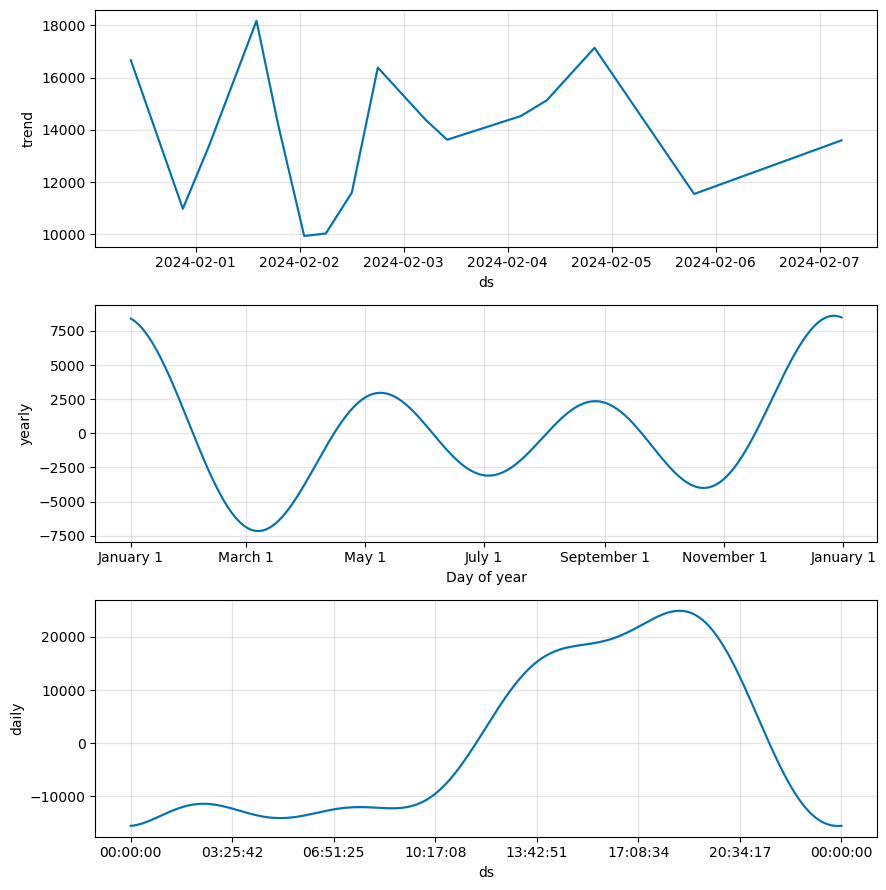

In [51]:
print("Single Model")
single_plot = single_prophet_model.plot_components(single_train_forecast)

Exog Model


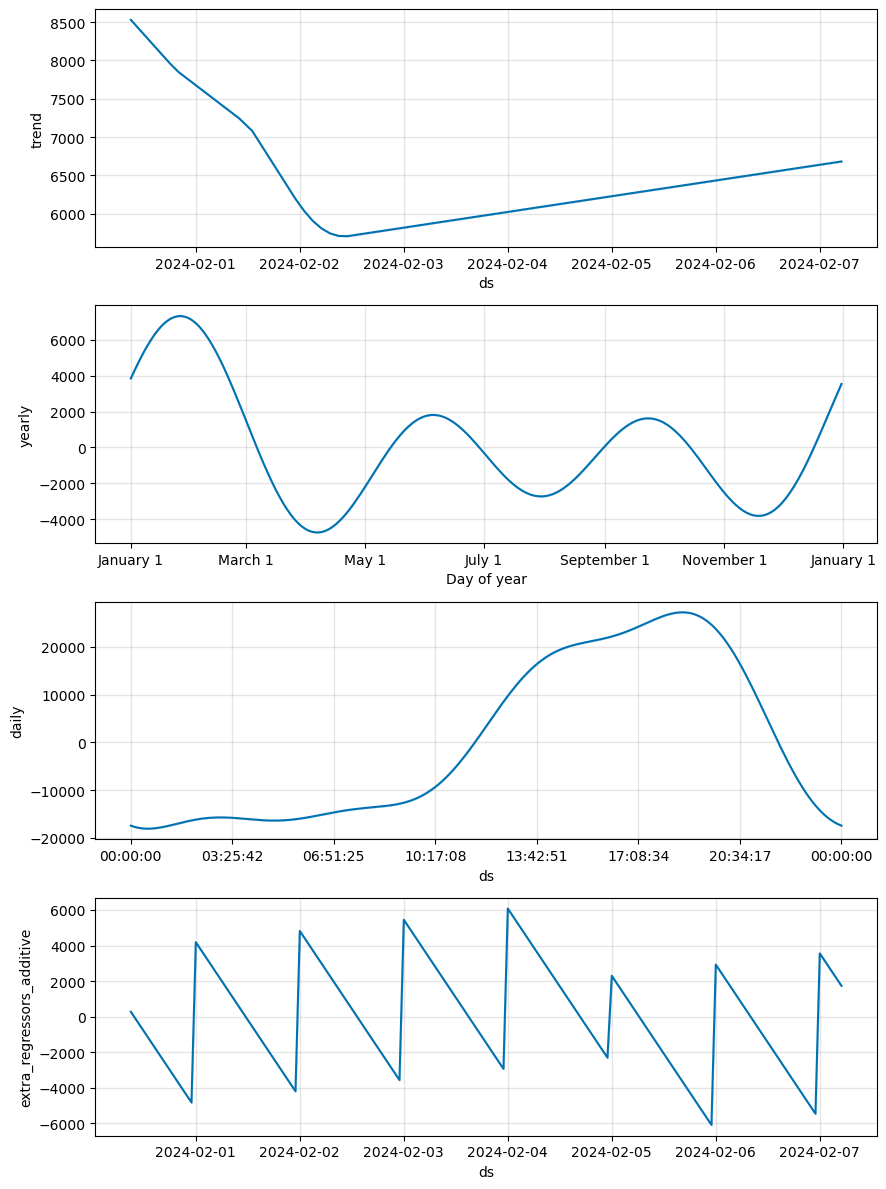

In [52]:
print("Exog Model")
exog_plot = exog_prophet_model.plot_components(exog_train_forecast)

Fancy Model


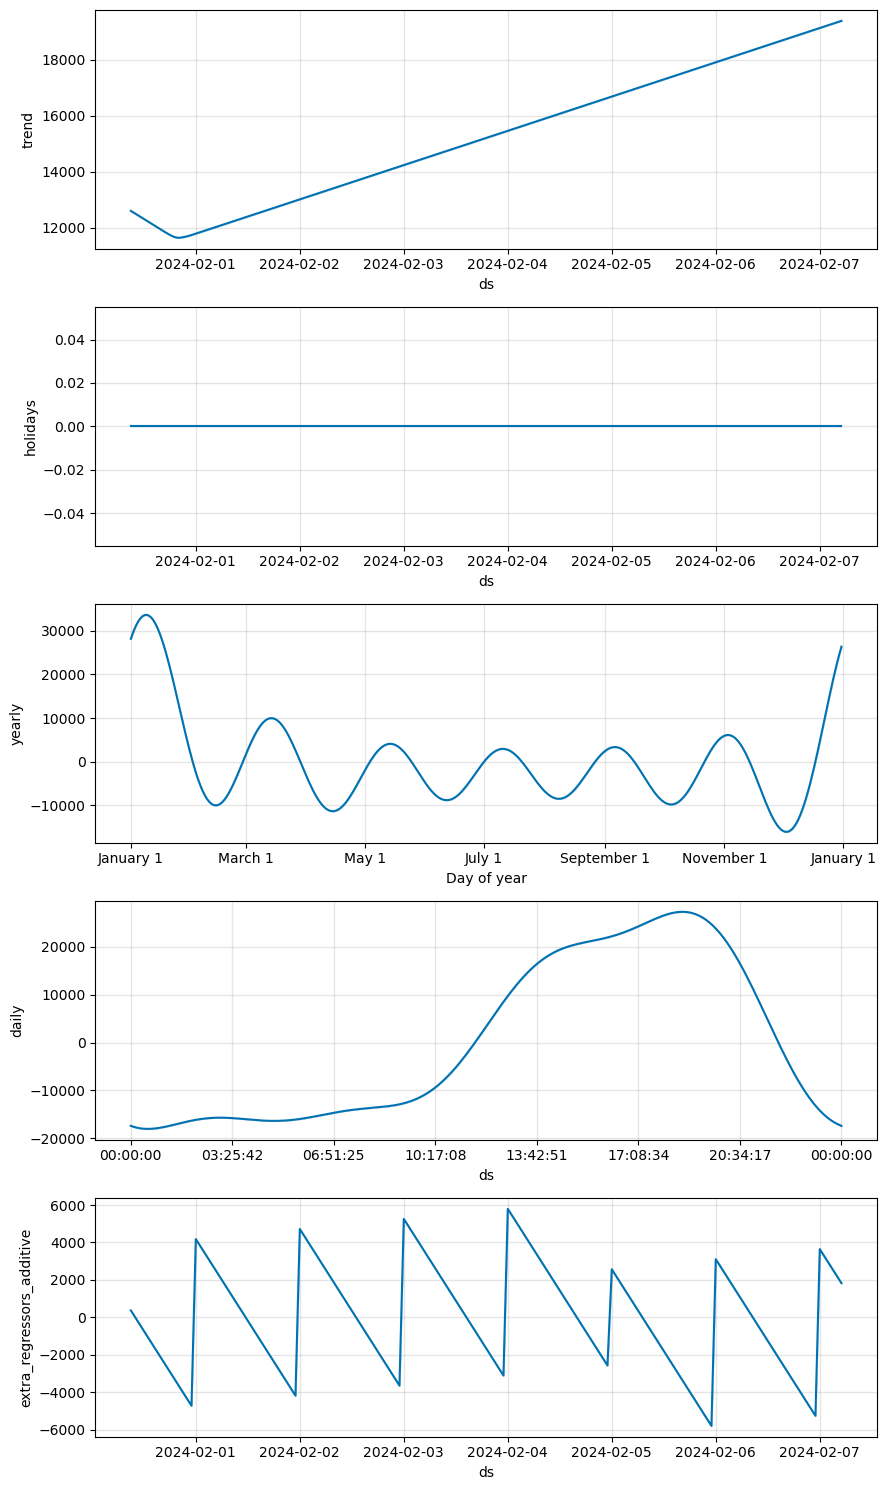

In [53]:
print("Fancy Model")
fancy_plot = fancy_prophet_model.plot_components(fancy_train_forecast)